## Import

In [295]:
import numpy as np
import cv2
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression



## Functions

In [296]:

def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def disp(img, title='', s=8, vmin=None, vmax=None, write=False, file_name=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    if write and file_name is not None:
        plt.savefig(file_name)
    plt.show()
    
def before_after(img_a, img_b, name="", vmin=None, vmax=None, effect_name="Processed"):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f"{name} Original")
    axs[1].set_title(f"{name} {effect_name}")
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()


## Loading Images

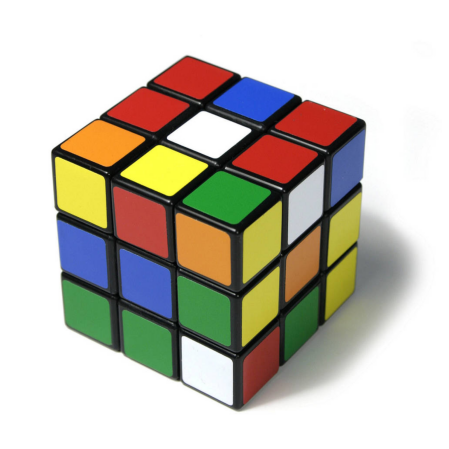

In [297]:
img_1 = rgb(cv2.imread("rubiks1_nologo.jpg"))
img_2 = rgb(cv2.imread("rubiks2.png"))
img_3 = rgb(cv2.imread("rubiks3.jpg"))
img_4 = rgb(cv2.imread("rubiks4.jpg"))
img_5 = rgb(cv2.imread("rubiks5.jpg"))

img_1_gray = cv2.imread("rubiks1_nologo.jpg", 0)
img_2_gray = cv2.imread("rubiks2.png", 0)
img_3_gray = cv2.imread("rubiks3.jpg", 0)
img_4_gray = cv2.imread("rubiks4.jpg", 0)
img_5_gray = cv2.imread("rubiks5.jpg", 0)

disp(img_1)

## Find Lines

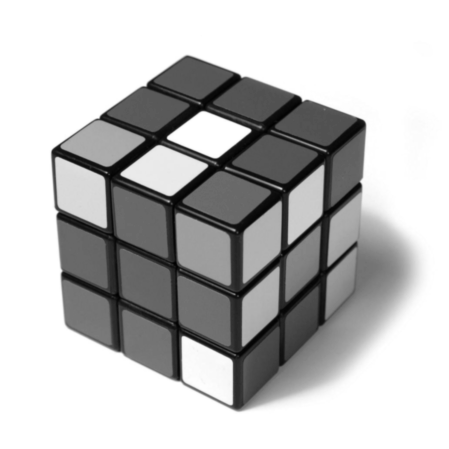

In [298]:
kernel_size = 5
blur_gray = cv2.GaussianBlur(img_1_gray,(kernel_size, kernel_size),0)
disp(blur_gray)

In [299]:
@interact(low_threshold=(0, 200, 1), high_threshold=(0, 200, 1))
def f(low_threshold = 160, high_threshold = 180):
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    disp(edges)

interactive(children=(IntSlider(value=160, description='low_threshold', max=200), IntSlider(value=180, descrip…

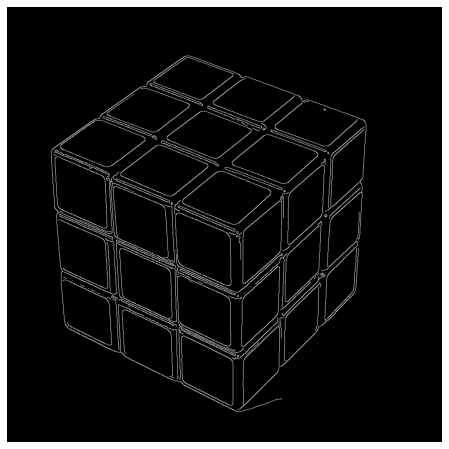

In [300]:
edges = cv2.Canny(blur_gray, 0, 75)
disp(edges)

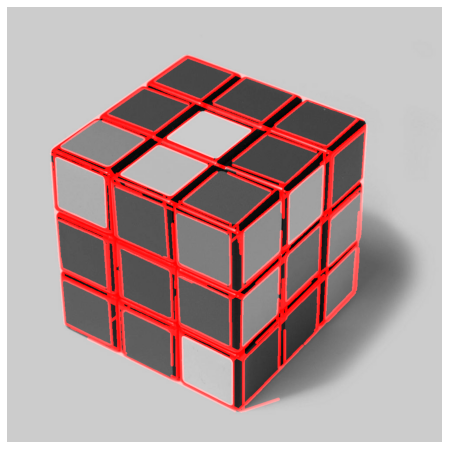

In [301]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img_1) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

angles = []
for line in lines:
    for x1,y1,x2,y2 in line:
        angle = cv2.fastAtan2(float(y2-y1), float(x2-x1))
        angles.append(angle)
        # print(angle)
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

# Draw the lines on the  image
img_1_gray_rgb = np.repeat(img_1_gray[:,:,None], 3, 2)
lines_edges = cv2.addWeighted(img_1_gray_rgb, 0.8, line_image, 1, 0)

disp(lines_edges)

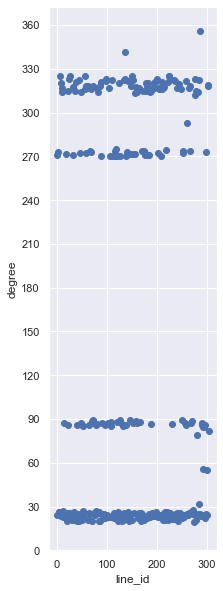

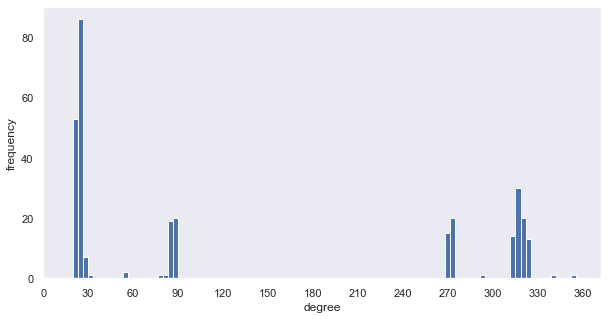

In [302]:
angles = np.array(angles)
plt.figure(figsize=(3,10))
plt.scatter(np.arange(len(angles)), angles)
plt.yticks(np.arange(0, 361, step=30))
plt.grid(True)
plt.ylabel("degree")
plt.xlabel("line_id")
plt.show()

plt.figure(figsize=(10,5))
plt.hist(angles.ravel(), bins=100)
plt.xticks(np.arange(0, 361, step=30))
plt.ylabel("frequency")
plt.xlabel("degree")
plt.show()

In [351]:
colors = [
    (245, 0, 87), #rgb(245, 0, 87)
    (0, 230, 118), #rgb(0, 230, 118)
    (25, 118, 210), #rgb(25, 118, 210)
    (245, 124, 0), #rgb(245, 124, 0)
    (124, 77, 255) #rgb(124, 77, 255)
]

colors_01 = [
    (245/255, 0/255, 87/255), #rgb(245, 0, 87)
    (0/255, 230/255, 118/255), #rgb(0, 230, 118)
    (25/255, 118/255, 210/255), #rgb(25, 118, 210)
    (245/255, 124/255, 0/255), #rgb(245, 124, 0)
    (124/255, 77/255, 255/255) #rgb(124, 77, 255)
]

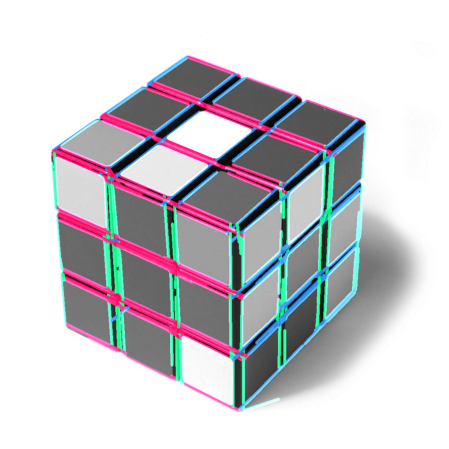

In [304]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img_1) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

angles = []
vertical_lines = []
negative_lines = []
positive_lines = []
for idx, line in enumerate(lines):
    for x1,y1,x2,y2 in line:
        angle = cv2.fastAtan2(float(y2-y1), float(x2-x1))
        if angle>=180:
            angle -= 180
        angles.append(angle)

        if 0<=angle<=60:
            cluster_id = 0
            positive_lines.append([x1,y1,x2,y2])
        if 60<=angle<=120:
            cluster_id = 1
            vertical_lines.append([x1,y1,x2,y2])
        if 120<=angle<=180:
            cluster_id = 2
            negative_lines.append([x1,y1,x2,y2])
            
        cv2.line(line_image,(x1,y1),(x2,y2),colors[cluster_id],5)

# Draw the lines on the  image
img_1_gray_rgb = np.repeat(img_1_gray[:,:,None], 3, 2)
lines_edges = cv2.addWeighted(img_1_gray_rgb, 1, line_image, 1, 0)

disp(lines_edges)

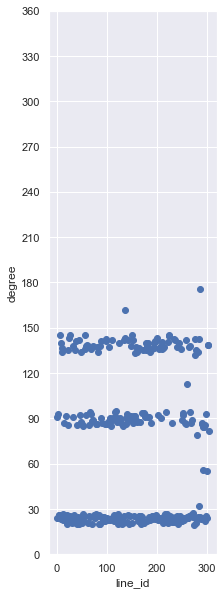

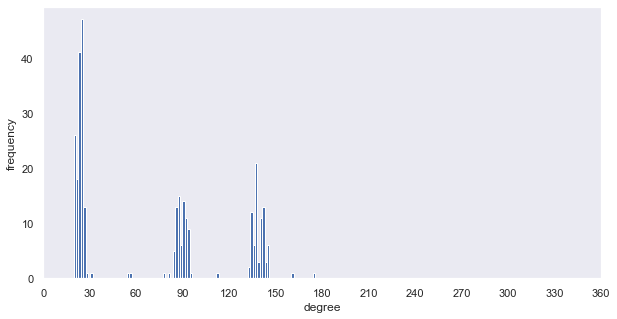

In [305]:
angles = np.array(angles)
plt.figure(figsize=(3,10))
plt.scatter(np.arange(len(angles)), angles)
plt.yticks(np.arange(0, 361, step=30))
plt.grid(True)
plt.ylabel("degree")
plt.xlabel("line_id")
plt.show()

plt.figure(figsize=(10,5))
plt.hist(angles.ravel(), bins=100)
plt.xticks(np.arange(0, 361, step=30))
plt.ylabel("frequency")
plt.xlabel("degree")
plt.show()

## Line types

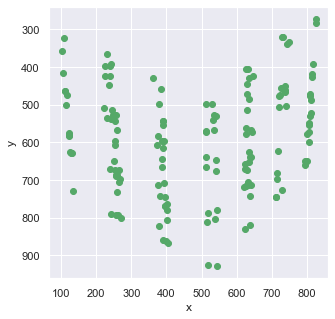

In [306]:
# vertical lines
points1 = np.zeros((len(vertical_lines)*2, 2))
for i in range(len(vertical_lines)):
    # point A on a line
    points1[2*i][0] = (vertical_lines[i][0])
    points1[2*i][1] = (vertical_lines[i][1])
    # point B on a line
    points1[2*i+1][0] = (vertical_lines[i][2])
    points1[2*i+1][1] = (vertical_lines[i][3])

    
plt.figure(figsize=(5,5))
plt.scatter(points1[:,0], points1[:,1], c='g')
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

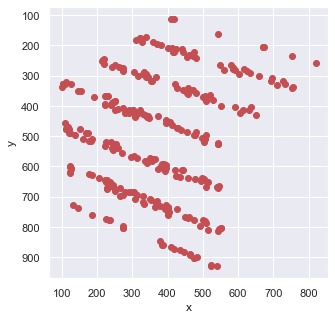

In [307]:
# positive lines
points2 = np.zeros((len(positive_lines)*2, 2))
for i in range(len(positive_lines)):
    # point A on a line
    points2[2*i][0] = (positive_lines[i][0])
    points2[2*i][1] = (positive_lines[i][1])
    # point B on a line
    points2[2*i+1][0] = (positive_lines[i][2])
    points2[2*i+1][1] = (positive_lines[i][3])
    
plt.figure(figsize=(5,5))
plt.scatter(points2[:,0], points2[:,1], c='r')
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

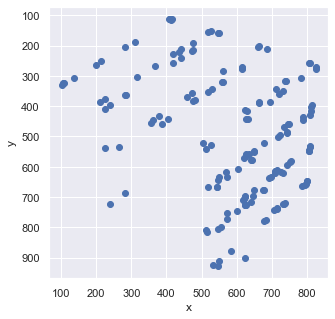

In [308]:
# vertical lines
points3 = np.zeros((len(negative_lines)*2, 2))
for i in range(len(negative_lines)):
    # point A on a line
    points3[2*i][0] = (negative_lines[i][0])
    points3[2*i][1] = (negative_lines[i][1])
    # point B on a line
    points3[2*i+1][0] = (negative_lines[i][2])
    points3[2*i+1][1] = (negative_lines[i][3])
    
plt.figure(figsize=(5,5))
plt.scatter(points3[:,0], points3[:,1])
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

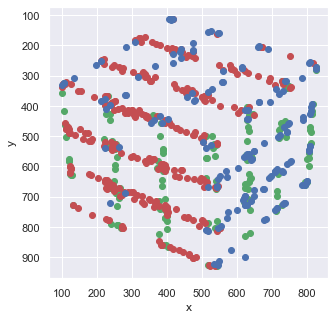

In [309]:
plt.figure(figsize=(5,5))
plt.scatter(points1[:,0], points1[:,1],c='g')
plt.scatter(points2[:,0], points2[:,1],c='r')
plt.scatter(points3[:,0], points3[:,1],c='b')
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

## Clustering

### Vertical Lines

Default clustering result: Bad

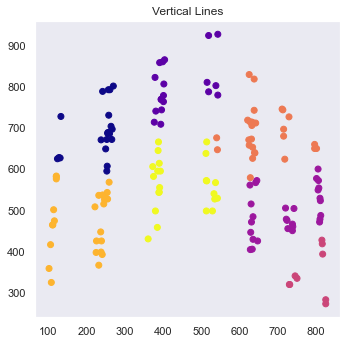

In [310]:
X = points1.copy()

y_pred_vertical_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_vertical_lines, cmap='plasma_r')
plt.title("Vertical Lines")
plt.show()

Divide the y component of the points by 10: Good

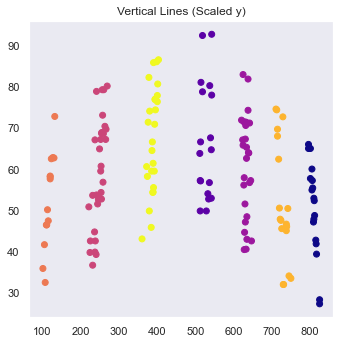

In [311]:
X = points1.copy()
X[:,1] /= 10

y_pred_vertical_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_vertical_lines, cmap='plasma_r')
plt.title("Vertical Lines (Scaled y)")
plt.show()

### Positive Lines

Default clustering result: Bad

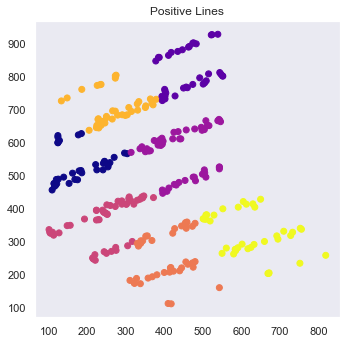

In [312]:
X = points2.copy()

y_pred_positive_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_positive_lines, cmap='plasma_r')
plt.title("Positive Lines")
plt.show()

Rotate the points by -60: Now they're like vertical lines

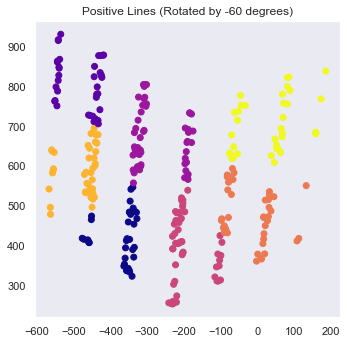

In [313]:
X = points2.copy()

# Let's Rotate the points by -60 degrees
theta = -60*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])
    
# Rotate the points
X_rotated = X @ R.T

y_pred_positive_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_positive_lines, cmap='plasma_r')
plt.title("Positive Lines (Rotated by -60 degrees)")
plt.show()

Divide the y component of the points by 10: Good

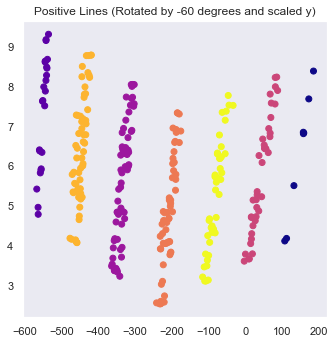

In [314]:
X = points2.copy()

# Let's Rotate the points by 60 degrees
theta = -60*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])

# Rotate the points
X_rotated = X @ R.T

X_rotated[:,1] /= 100

y_pred_positive_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_positive_lines, cmap='plasma_r')
plt.title("Positive Lines (Rotated by -60 degrees and scaled y)")
plt.show()

### Negative Lines

Default clustering result: Bad

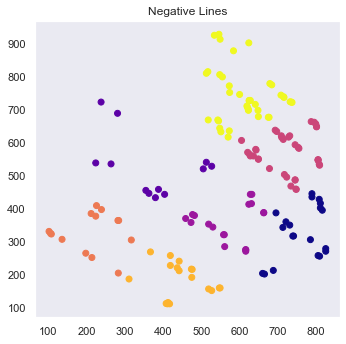

In [315]:
X = points3.copy()

y_pred_negative_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_negative_lines, cmap='plasma_r')
plt.title("Negative Lines")
plt.show()

Rotate the points by +60: Now they're like vertical lines

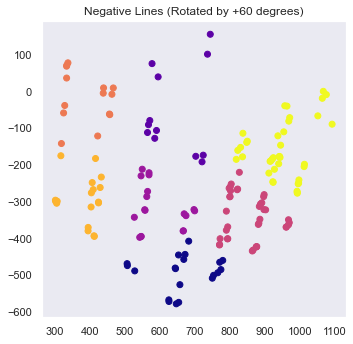

In [316]:
X = points3.copy()

# Let's Rotate the points by -60 degrees
theta = 60*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])
    
# Rotate the points
X_rotated = X @ R.T

y_pred_negative_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_negative_lines, cmap='plasma_r')
plt.title("Negative Lines (Rotated by +60 degrees)")
plt.show()

Divide the y component of the points by 10: Good

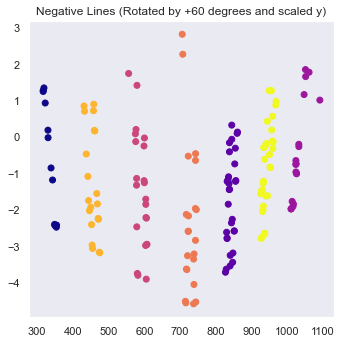

In [326]:
X = points3.copy()

# Let's Rotate the points by 60 degrees
theta = 50*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])

# Rotate the points
X_rotated = X @ R.T

X_rotated[:,1] /= 100

y_pred_negative_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_negative_lines, cmap='plasma_r')
plt.title("Negative Lines (Rotated by +60 degrees and scaled y)")
plt.show()

## Line Fitting

### Vertical Lines

Coefficients: 
 -0.008009891427943007
Intercept: 
 637.8888944465552


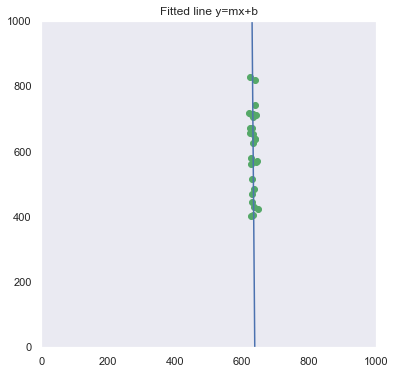

In [327]:
# Select only one cluster
cluster_id =4
X = points1.copy()[y_pred_vertical_lines==cluster_id]

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X[:,1].reshape(-1, 1), X[:,0])

# The coefficients
print("Coefficients: \n", regr.coef_[0])
print("Intercept: \n", regr.intercept_)

m = regr.coef_[0]
b = regr.intercept_

x = np.arange(0,img_1.shape[1])
y = m*x+b

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c='g', cmap='plasma_r')
plt.plot(y, x)
plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.title("Fitted line y=mx+b")

plt.show()


In [337]:
fitted_ms_all = []
fitted_bs_all = []
scalers_all = []

In [338]:
fitted_ms = []
fitted_bs = []
scalers = []

# vertical lines
for cluster_id in range(7):
    X = points1.copy()[y_pred_vertical_lines==cluster_id]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    scalers.append(scaler)

    regr = LinearRegression()
    regr.fit(X[:,1].reshape(-1, 1), X[:,0])

    m = regr.coef_[0]
    b = regr.intercept_

    fitted_ms.append(m)
    fitted_bs.append(b)

fitted_ms_all.append(fitted_ms)
fitted_bs_all.append(fitted_bs)
scalers_all.append(scalers)

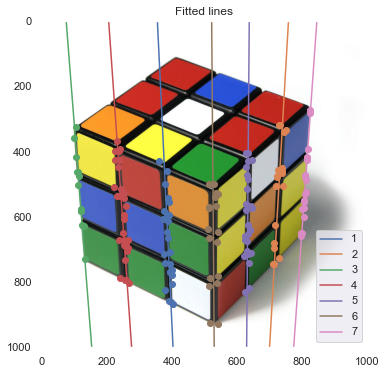

In [339]:
plt.figure(figsize=(6, 6))
plt.imshow(img_1)
for cluster_id in range(7):
    # Get the points of this cluster
    X = points1.copy()[y_pred_vertical_lines==cluster_id]
    
    # Get the corresponding scaler
    scaler = scalers[cluster_id]

    # Calculate the points in the current line
    x = np.arange(0,img_1.shape[1])
    # Scale the x values so that they work with m and b
    x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
    y = fitted_ms[cluster_id]*x+fitted_bs[cluster_id]

    # Concatenate fitted line's x and y
    line_X = np.column_stack([y, x])
    
    # Inverse Scaler transform
    line_X = scaler.inverse_transform(line_X)

    plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
    plt.plot(line_X[:, 0], line_X[:, 1])

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


### Positive Lines

In [340]:
fitted_ms = []
fitted_bs = []
scalers = []

# Positive lines
for cluster_id in range(7):
    X = points2.copy()[y_pred_positive_lines==cluster_id]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    scalers.append(scaler)

    regr = LinearRegression()
    regr.fit(X[:,0].reshape(-1, 1), X[:,1])

    m = regr.coef_[0]
    b = regr.intercept_

    fitted_ms.append(m)
    fitted_bs.append(b)

fitted_ms_all.append(fitted_ms)
fitted_bs_all.append(fitted_bs)
scalers_all.append(scalers)

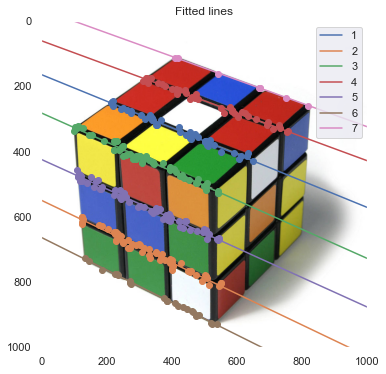

In [341]:
plt.figure(figsize=(6, 6))
plt.imshow(img_1)
for cluster_id in range(7):
    # Get the points of this cluster
    X = points2.copy()[y_pred_positive_lines==cluster_id]
    
    # Get the corresponding scaler
    scaler = scalers[cluster_id]

    # Calculate the points in the current line
    x = np.arange(0,img_1.shape[1])
    # Scale the x values so that they work with m and b
    x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
    y = fitted_ms[cluster_id]*x+fitted_bs[cluster_id]

    # Concatenate fitted line's x and y
    line_X = np.column_stack([x,y])
    
    # Inverse Scaler transform
    line_X = scaler.inverse_transform(line_X)

    plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
    plt.plot(line_X[:, 0], line_X[:, 1])

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


### Negative Lines

In [342]:
fitted_ms = []
fitted_bs = []
scalers = []

# Negative lines
for cluster_id in range(7):
    X = points3.copy()[y_pred_negative_lines==cluster_id]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    scalers.append(scaler)

    regr = LinearRegression()
    regr.fit(X[:,0].reshape(-1, 1), X[:,1])

    m = regr.coef_[0]
    b = regr.intercept_

    fitted_ms.append(m)
    fitted_bs.append(b)

fitted_ms_all.append(fitted_ms)
fitted_bs_all.append(fitted_bs)
scalers_all.append(scalers)

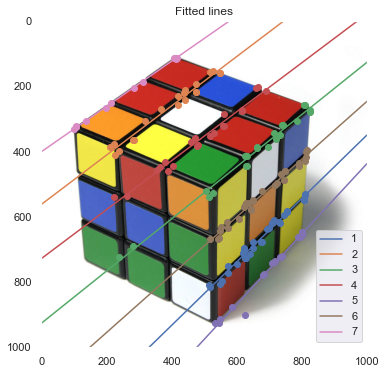

In [343]:
plt.figure(figsize=(6, 6))
plt.imshow(img_1)
for cluster_id in range(7):
    # Get the points of this cluster
    X = points3.copy()[y_pred_negative_lines==cluster_id]
    
    # Get the corresponding scaler
    scaler = scalers[cluster_id]

    # Calculate the points in the current line
    x = np.arange(0,img_1.shape[1])
    # Scale the x values so that they work with m and b
    x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
    y = fitted_ms[cluster_id]*x+fitted_bs[cluster_id]

    # Concatenate fitted line's x and y
    line_X = np.column_stack([x,y])
    
    # Inverse Scaler transform
    line_X = scaler.inverse_transform(line_X)

    plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
    plt.plot(line_X[:, 0], line_X[:, 1])

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


### All together

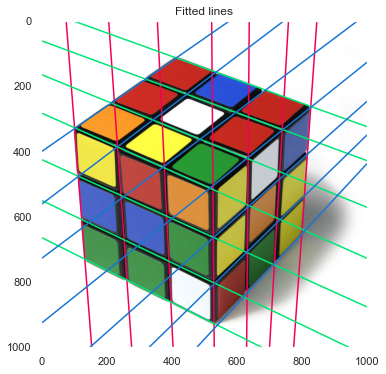

In [359]:
plt.figure(figsize=(6, 6))
plt.imshow(img_1)

for i in range(3):
    for cluster_id in range(7):
        # Get the points of this cluster
        if i==0:
            X = points1.copy()[y_pred_vertical_lines==cluster_id]
        elif i==1:
            X = points2.copy()[y_pred_positive_lines==cluster_id]
        elif i==2:
            X = points3.copy()[y_pred_negative_lines==cluster_id]
        
        # Get the corresponding scaler
        scaler = scalers_all[i][cluster_id]

        # Calculate the points in the current line
        x = np.arange(0,img_1.shape[1])

        # Scale the x values so that they work with m and b
        x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
        y = fitted_ms_all[i][cluster_id]*x+fitted_bs_all[i][cluster_id]

        # Concatenate fitted line's x and y
        if i==0:
            line_X = np.column_stack([y,x])
        else:
            line_X = np.column_stack([x,y])
        
        # Inverse Scaler transform
        line_X = scaler.inverse_transform(line_X)

        # plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
        plt.plot(line_X[:, 0], line_X[:, 1], c=colors_01[i], linewidth=1.5)

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
# plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


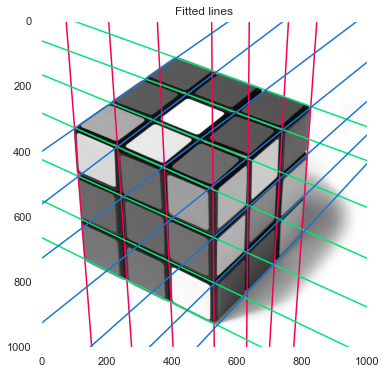

In [360]:
plt.figure(figsize=(6, 6))
plt.imshow(img_1_gray_rgb)

for i in range(3):
    for cluster_id in range(7):
        # Get the points of this cluster
        if i==0:
            X = points1.copy()[y_pred_vertical_lines==cluster_id]
        elif i==1:
            X = points2.copy()[y_pred_positive_lines==cluster_id]
        elif i==2:
            X = points3.copy()[y_pred_negative_lines==cluster_id]
        
        # Get the corresponding scaler
        scaler = scalers_all[i][cluster_id]

        # Calculate the points in the current line
        x = np.arange(0,img_1.shape[1])

        # Scale the x values so that they work with m and b
        x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
        y = fitted_ms_all[i][cluster_id]*x+fitted_bs_all[i][cluster_id]

        # Concatenate fitted line's x and y
        if i==0:
            line_X = np.column_stack([y,x])
        else:
            line_X = np.column_stack([x,y])
        
        # Inverse Scaler transform
        line_X = scaler.inverse_transform(line_X)

        # plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
        plt.plot(line_X[:, 0], line_X[:, 1], c=colors_01[i], linewidth=1.5)

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
# plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()
